In [175]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import pandas as pd

%matplotlib inline
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from cycler import cycler
from PIL import Image
from torchvision import datasets, transforms
import tqdm

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 2.3.0


In [176]:
margin_param=0.2

In [177]:
x = pd.read_csv('../dataset/X.csv')
y = pd.read_csv('../dataset/y.csv')

In [180]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class MyNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x

input_size = x.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 20


model = MyNN(input_size, hidden_size1, hidden_size2, output_size)

In [181]:
class ItemDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values,dtype=torch.float32,requires_grad=True)
        self.y = torch.tensor(y.values).flatten()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = ItemDataset(x, y)

In [182]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
loss = losses.TripletMarginLoss(margin=margin_param)
miner= miners.TripletMarginMiner(margin=margin_param, type_of_triplets="hard")
sampler = samplers.MPerClassSampler(y, m=4, length_before_new_iter=len(train_dataset))

batch_size = 128
num_epochs = 10
dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

losses = []
for epoch in tqdm.tqdm(range(num_epochs)):
    
    local_loss = 0
    for i, (data,label) in enumerate(dataloader):
        optimizer.zero_grad()
        embeddings = model(data)
        hard_pairs = miner(embeddings, label)
        loss_value = loss(embeddings, label, hard_pairs)
        loss_value.backward()
        local_loss += loss_value.item()
        optimizer.step()
    losses.append(local_loss)
    print(local_loss)

100%|██████████| 1/1 [06:21<00:00, 381.78s/it]

0.0


In [183]:
torch.save(model.state_dict(), 'model.pth')

In [184]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [199]:
from pytorch_metric_learning.distances import LpDistance
def get_embedding(model, x):
    return model(torch.tensor(x.values,dtype=torch.float32,requires_grad=True))

def get_recommendation(model, x, item_id,k=10,embeddings=None):
    if embeddings is None:  
        embeddings = get_embedding(model, x)
    
    Lp = LpDistance(normalize_embeddings=False)
    Lp_sim = Lp(embeddings, embeddings[item_id].unsqueeze(0))
    
    idx = torch.argsort(Lp_sim.squeeze())

    topk=list(zip(idx.tolist(), Lp_sim[idx].tolist()))
    
    topk.sort(key=lambda x: x[1],reverse=True)
    return topk[:k]

In [200]:
product_data = pd.read_csv('dataset/product_data_cleaned.csv')
id = product_data.iloc[8000]["cod_modelo_color"]
row_number = product_data[product_data["cod_modelo_color"] == id].index[0]

top100 = get_recommendation(model, x, row_number)

AttributeError: 'str' object has no attribute 'values'

In [ ]:
# select a random id from 0 to len(product_data)
id = random.randint(0, len(product_data))
random_id = product_data.iloc[id]["cod_modelo_color"]
top100 = get_recommendation(model, x, id, k=1000)

top100[:10]

AttributeError: 'str' object has no attribute 'values'

In [ ]:
# get x columns not containing "weight" in name
imp=x.columns[x.columns.str.contains("weight") == False]
x[imp].iloc[1234]

des_agrup_color_eng_BLUE      0.000000
des_agrup_color_eng_BROWN     1.000000
des_agrup_color_eng_GREEN     0.000000
des_agrup_color_eng_GREY      0.000000
des_agrup_color_eng_ORANGE    0.000000
                                ...   
Weight_4092                   0.015328
Weight_4093                   0.027372
Weight_4094                   0.000000
Weight_4095                   0.000000
Weight_4096                   0.000000
Name: 1234, Length: 4240, dtype: float64

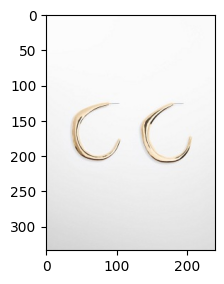

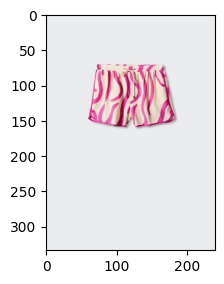

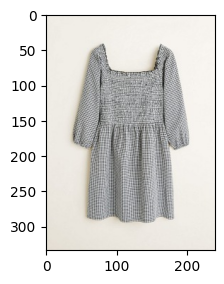

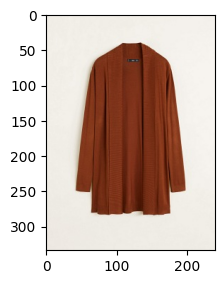

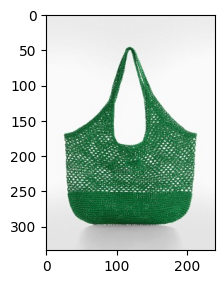

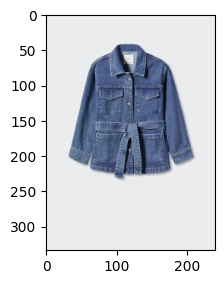

In [ ]:
categories = product_data["des_product_category"].unique().tolist()

# create a dictionry with the categoreis as keys and 0 values for each category
category_dict = {}
for category in categories:
    category_dict[category] = []
    
# fill the dictionary with the top 100 recommendations for each category
for item in top100:
    category = product_data.iloc[item[0]]["des_product_category"]
    category_dict[category].append(item[0])

display_images([get_image_path(product_data.iloc[id]["cod_modelo_color"], product_data)])

for category in category_dict:
    x = product_data.iloc[category_dict[category][0]]["cod_modelo_color"]
    display_images([get_image_path(x, product_data)])

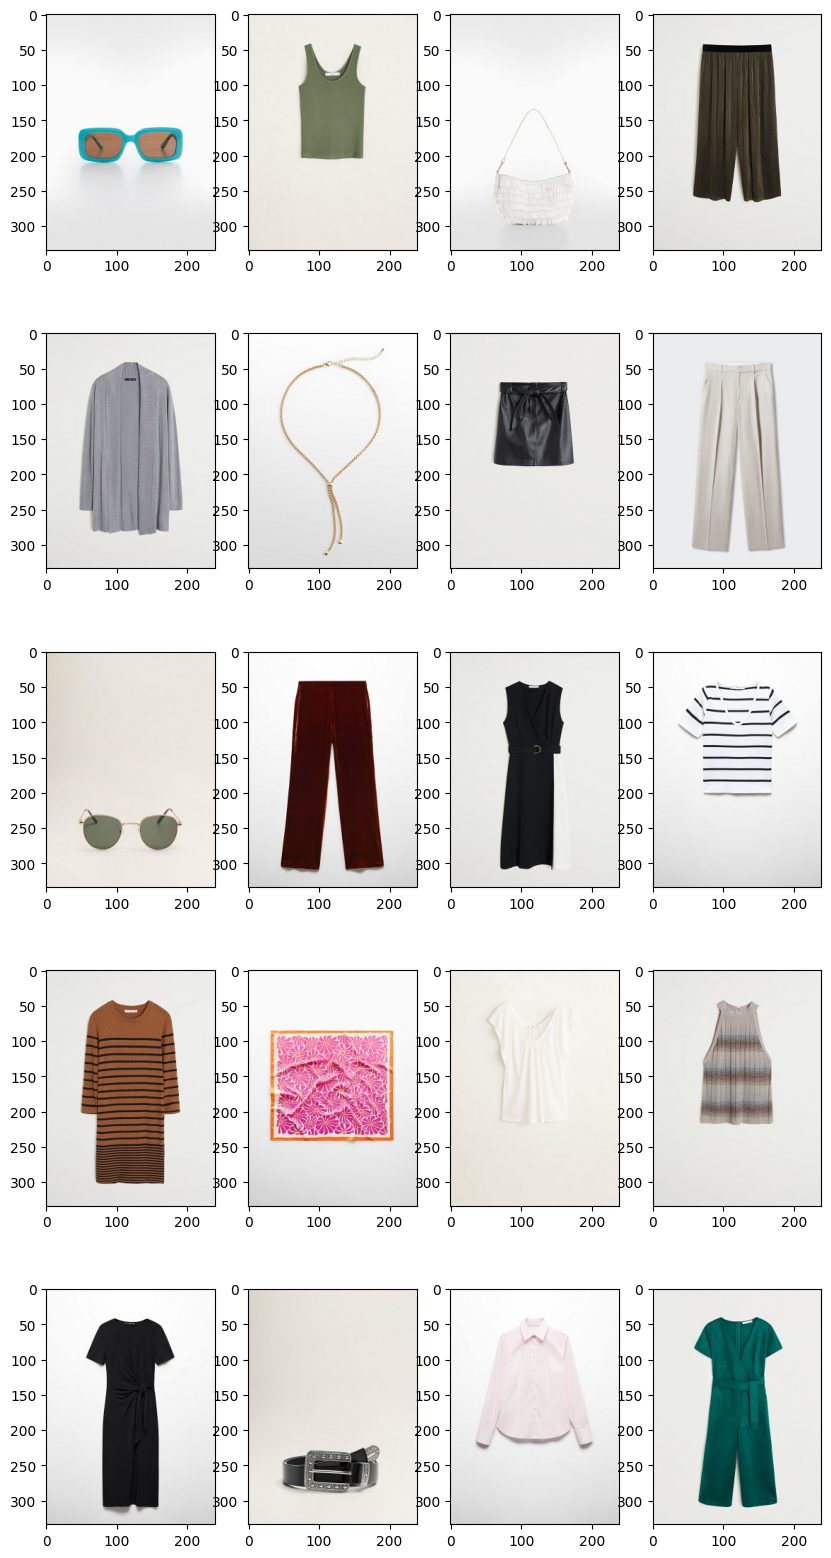

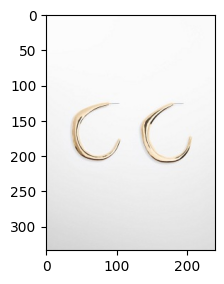

In [ ]:

display_images([get_image_path(dict_index_modelo[top[0]], product_data) for top in top100]) 


display_images([get_image_path(random_id, product_data)])

In [ ]:
product_data['des_product_category'].unique()

array(['Bottoms', 'Dresses, jumpsuits and Complete set', 'Tops',
       'Accesories, Swim and Intimate', 'Outerwear'], dtype=object)

In [ ]:
row_number

8000

In [ ]:
import matplotlib.pyplot as plt
def display_images(paths):
    fig=plt.figure(figsize=(10, 20))
    columns = 4
    rows = 5
    for i in range(1, min(columns*rows +1, len(paths)+1)):
        img = plt.imread(paths[i-1][9:])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

def get_image_path(cod_modelo_color, outfit_data):
    return outfit_data[outfit_data['cod_modelo_color'] == cod_modelo_color]['des_filename'].values[0]
  
# load from datasets dict_index_modelo pickle 
import pickle
with open('dataset/dict_index_modelo.pickle', 'rb') as handle:
    dict_index_modelo = pickle.load(handle)

In [ ]:
# display id image
display_images([get_image_path(id, product_data)])

IndexError: index 0 is out of bounds for axis 0 with size 0

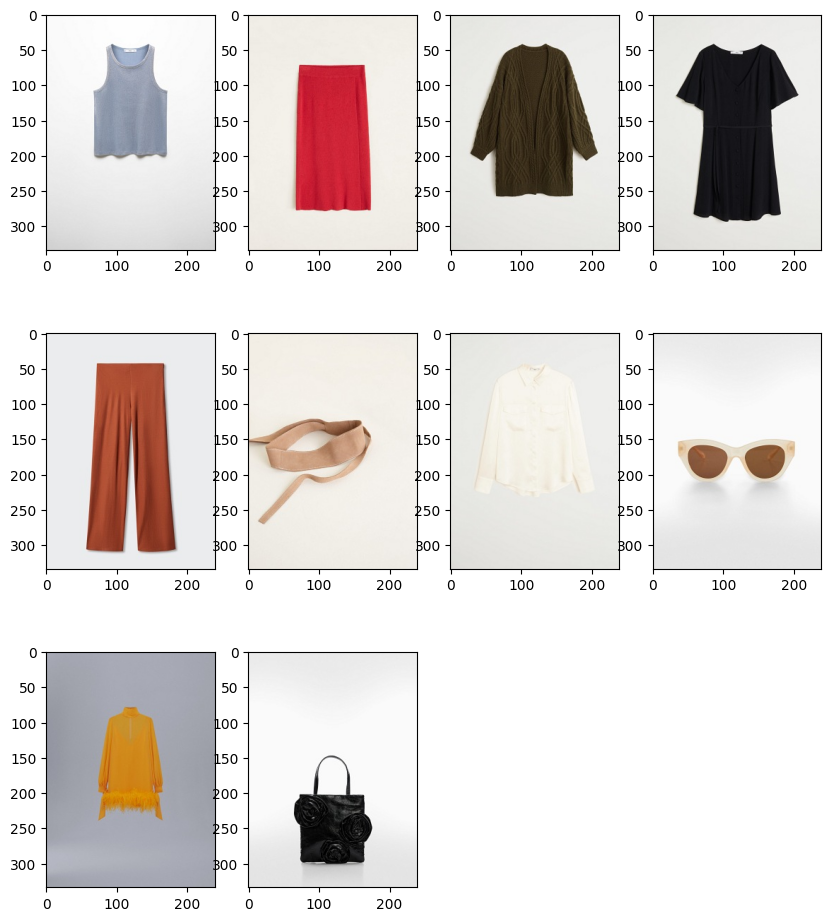

In [ ]:
display_images([get_image_path(dict_index_modelo[top[0]], product_data) for top in top100])

In [ ]:
product_data.shape

(8986, 9)

In [ ]:
x.shape

(8985, 4240)